In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import OrderedDict
import pandasql as ps

In [77]:
class Median_Filler:
    def __init__(self, file_name):
        self.master_data = pd.read_excel(file_name)
        print('DATA LOADED')
        self.group_col_seq = []
        self.value_col_seq = []
        self.threshold_cols = 0
        self.grouped_data = {}
        self.rename_cols()
        
    def rename_cols(self):
        self.master_data.columns = self.master_data.columns.str.strip().str.replace('.', '_')

    def display_missing_heatmap(self, column):
        print('Number of missing values = ', self.master_data[column].isnull().sum())
        print(
            '% of missing values = ',
            round(self.master_data[column].isnull().sum()* 100/len(self.master_data),2),
            '%'
        )
        sns.heatmap(
            pd.DataFrame(self.master_data[column]).isnull(),
            yticklabels=False,
            cbar=False,
            cmap='viridis'
        )
    
    def generate_data(self,config):
        self.set_config(config)
        self.gen_grouped_df()

    def set_config(self, config):
        self.group_col_seq = config['group_col_seq']
        self.value_col_seq = config['value_col_seq']
        self.threshold_cols = config['threshold_cols']
    
    def gen_grouped_df(self):
        group_col_seq = self.group_col_seq
        value_col_seq = self.value_col_seq
        threshold_cols = self.threshold_cols
        input_df = self.master_data

        df_dict = OrderedDict()
        for i in list(range(len(group_col_seq)))[::-1]:
            if i < threshold_cols - 1:
                break
            group_cols = group_col_seq[:i+1]
            print('Grouping data on --> Level ',i+1,' on Columns: ', group_cols)
            grouped_df = pd.DataFrame(input_df.groupby(group_cols)[value_col_seq].median()).reset_index()
            grouped_df.dropna(inplace=True)
            grouped_df = grouped_df.reset_index()
            grouped_df.rename(columns={'index': 'UID'}, inplace=True)
            df_dict[i+1] = {
                'df': grouped_df,
                'group_cols': group_col_seq[:i+1],
                'value_cols': value_col_seq
            }
        self.grouped_data = df_dict

    def lookup_val(self, inp_frame):
        level_data = self.grouped_data
        for i in level_data:
            # Load data
            curr_level = level_data[i]['df']
            group_cols = level_data[i]['group_cols']
            val_cols = level_data[i]['value_cols'] + ['UID']
            # Generate Query
            query = 'SELECT '
            query += ','.join(val_cols)
            query += ' from curr_level where '
            query += ' and '.join([col + ' = ' + "'" + str(inp_frame[col].values[0]) + "'" for col in group_cols])
            query += ';'
            # print('Level --> ',i,' Query -->', query)
            try:
                res = ps.sqldf(query, {'curr_level':curr_level})
            except:
                print('Error in processing record', 'Level --> ',i,' Query -->', query)
                return None
            if not res.empty:
                res['Level'] = i
                return res
        return None
    
    def get_missing_index(self, col_name):
        index = self.master_data[col_name].index[self.master_data[col_name].apply(np.isnan)]
        return list(index)
    
    def fill_values(self, col_name):
        if col_name not in self.value_col_seq:
            raise Exception('Input column not in grouped configuration')
        miss_index = self.get_missing_index(col_name)
        print(len(miss_index))
        for i in miss_index:
            inp_frame = self.master_data.loc[[i]]
            res = self.lookup_val(inp_frame)
            if res is not None:
                miss_value = res[col_name].values
                self.master_data.at[i, col_name] = miss_value
            else:
                print('No value found for record', i)
    
    def dump_to_excel(self, file_name):
        self.master_data.to_excel(file_name)
    


In [89]:
co2 = Median_Filler('data.xlsx')

DATA LOADED


In [90]:
# config
conf = {
    'group_col_seq':  ['TR_CoRPrimaryCountry', 'TR_GICSSector','TR_GICSIndustry','TR_GICSSubIndustry'],
    'value_col_seq' : ['TR_AnalyticCO2IndirectScope3', 'TR_AnalyticTotalWaste', 'TR_AnalyticSalaryGap'],
    'threshold_cols' : 0
}
co2.generate_data(conf)

Grouping data on --> Level  4  on Columns:  ['TR_CoRPrimaryCountry', 'TR_GICSSector', 'TR_GICSIndustry', 'TR_GICSSubIndustry']
Grouping data on --> Level  3  on Columns:  ['TR_CoRPrimaryCountry', 'TR_GICSSector', 'TR_GICSIndustry']
Grouping data on --> Level  2  on Columns:  ['TR_CoRPrimaryCountry', 'TR_GICSSector']
Grouping data on --> Level  1  on Columns:  ['TR_CoRPrimaryCountry']


Number of missing values =  6527
% of missing values =  87.66 %


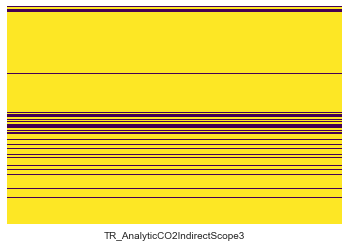

In [91]:
co2.display_missing_heatmap('TR_AnalyticCO2IndirectScope3')

In [92]:
co2.fill_values('TR_AnalyticCO2IndirectScope3')

6527
No value found for record 352
Error in processing record Level -->  4  Query --> SELECT TR_AnalyticCO2IndirectScope3,TR_AnalyticTotalWaste,TR_AnalyticSalaryGap,UID from curr_level where TR_CoRPrimaryCountry = 'UNITED STATES' and TR_GICSSector = 'Financials' and TR_GICSIndustry = 'Mortgage Real Estate Investment Trusts (REITs)' and TR_GICSSubIndustry = 'Mortgage REIT's';
No value found for record 400
No value found for record 456
No value found for record 497
No value found for record 528
Error in processing record Level -->  4  Query --> SELECT TR_AnalyticCO2IndirectScope3,TR_AnalyticTotalWaste,TR_AnalyticSalaryGap,UID from curr_level where TR_CoRPrimaryCountry = 'UNITED STATES' and TR_GICSSector = 'Financials' and TR_GICSIndustry = 'Mortgage Real Estate Investment Trusts (REITs)' and TR_GICSSubIndustry = 'Mortgage REIT's';
No value found for record 548
No value found for record 596
No value found for record 606
Error in processing record Level -->  4  Query --> SELECT TR_Analytic

Error in processing record Level -->  4  Query --> SELECT TR_AnalyticCO2IndirectScope3,TR_AnalyticTotalWaste,TR_AnalyticSalaryGap,UID from curr_level where TR_CoRPrimaryCountry = 'UNITED STATES' and TR_GICSSector = 'Financials' and TR_GICSIndustry = 'Mortgage Real Estate Investment Trusts (REITs)' and TR_GICSSubIndustry = 'Mortgage REIT's';
No value found for record 2009
No value found for record 2040
No value found for record 2048
Error in processing record Level -->  4  Query --> SELECT TR_AnalyticCO2IndirectScope3,TR_AnalyticTotalWaste,TR_AnalyticSalaryGap,UID from curr_level where TR_CoRPrimaryCountry = 'UNITED STATES' and TR_GICSSector = 'Financials' and TR_GICSIndustry = 'Mortgage Real Estate Investment Trusts (REITs)' and TR_GICSSubIndustry = 'Mortgage REIT's';
No value found for record 2113
Error in processing record Level -->  4  Query --> SELECT TR_AnalyticCO2IndirectScope3,TR_AnalyticTotalWaste,TR_AnalyticSalaryGap,UID from curr_level where TR_CoRPrimaryCountry = 'UNITED STA

No value found for record 3898
No value found for record 3912
No value found for record 3919
No value found for record 3928
No value found for record 3936
No value found for record 3941
No value found for record 3943
No value found for record 3944
No value found for record 3947
No value found for record 3950
No value found for record 3962
No value found for record 3964
No value found for record 3975
No value found for record 3982
No value found for record 3983
No value found for record 3984
No value found for record 3987
No value found for record 3997
No value found for record 4001
No value found for record 4009
No value found for record 4011
No value found for record 4045
No value found for record 4051
No value found for record 4063
No value found for record 4075
No value found for record 4081
No value found for record 4084
No value found for record 4091
No value found for record 4093
No value found for record 4096
No value found for record 4100
No value found for record 4103
No value

No value found for record 5123
No value found for record 5124
No value found for record 5126
No value found for record 5130
No value found for record 5131
No value found for record 5134
No value found for record 5138
No value found for record 5140
No value found for record 5142
No value found for record 5144
No value found for record 5145
No value found for record 5150
No value found for record 5153
No value found for record 5161
No value found for record 5166
No value found for record 5171
No value found for record 5181
No value found for record 5182
No value found for record 5183
No value found for record 5186
No value found for record 5187
No value found for record 5188
No value found for record 5198
No value found for record 5210
No value found for record 5211
No value found for record 5214
No value found for record 5216
No value found for record 5221
No value found for record 5222
No value found for record 5223
No value found for record 5224
No value found for record 5225
No value

No value found for record 5999
No value found for record 6000
No value found for record 6002
No value found for record 6003
No value found for record 6004
No value found for record 6009
No value found for record 6012
No value found for record 6016
No value found for record 6018
No value found for record 6020
No value found for record 6021
No value found for record 6025
No value found for record 6027
No value found for record 6028
No value found for record 6029
No value found for record 6032
No value found for record 6033
No value found for record 6034
No value found for record 6035
No value found for record 6036
No value found for record 6037
No value found for record 6038
No value found for record 6042
No value found for record 6043
No value found for record 6044
No value found for record 6047
No value found for record 6055
No value found for record 6058
No value found for record 6059
No value found for record 6060
No value found for record 6062
No value found for record 6063
No value

No value found for record 6542
No value found for record 6543
No value found for record 6551
No value found for record 6552
No value found for record 6553
No value found for record 6554
No value found for record 6556
No value found for record 6558
No value found for record 6562
No value found for record 6567
No value found for record 6568
No value found for record 6570
No value found for record 6572
No value found for record 6573
No value found for record 6574
No value found for record 6576
No value found for record 6581
No value found for record 6582
No value found for record 6584
No value found for record 6585
No value found for record 6588
No value found for record 6590
No value found for record 6592
No value found for record 6594
No value found for record 6596
No value found for record 6598
No value found for record 6602
No value found for record 6603
No value found for record 6604
No value found for record 6605
No value found for record 6606
No value found for record 6607
No value

No value found for record 7083
No value found for record 7088
No value found for record 7090
No value found for record 7091
No value found for record 7092
No value found for record 7094
No value found for record 7095
No value found for record 7099
No value found for record 7100
No value found for record 7101
No value found for record 7102
No value found for record 7103
No value found for record 7107
No value found for record 7109
No value found for record 7112
No value found for record 7114
No value found for record 7118
No value found for record 7119
No value found for record 7120
No value found for record 7121
No value found for record 7124
No value found for record 7125
No value found for record 7126
No value found for record 7131
No value found for record 7133
No value found for record 7134
No value found for record 7135
No value found for record 7136
No value found for record 7137
No value found for record 7138
No value found for record 7139
No value found for record 7140
No value

Number of missing values =  1345
% of missing values =  18.06 %


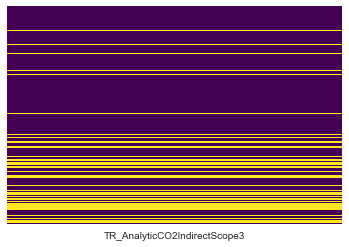

In [93]:
co2.display_missing_heatmap('TR_AnalyticCO2IndirectScope3')

Number of missing values =  6272
% of missing values =  84.23 %


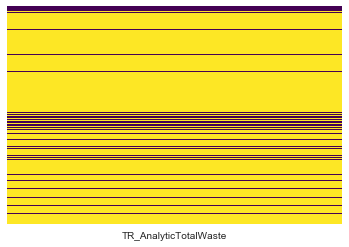

In [94]:
co2.display_missing_heatmap('TR_AnalyticTotalWaste')

In [95]:
co2.fill_values('TR_AnalyticTotalWaste')

6272
No value found for record 352
Error in processing record Level -->  4  Query --> SELECT TR_AnalyticCO2IndirectScope3,TR_AnalyticTotalWaste,TR_AnalyticSalaryGap,UID from curr_level where TR_CoRPrimaryCountry = 'UNITED STATES' and TR_GICSSector = 'Financials' and TR_GICSIndustry = 'Mortgage Real Estate Investment Trusts (REITs)' and TR_GICSSubIndustry = 'Mortgage REIT's';
No value found for record 400
No value found for record 456
No value found for record 497
No value found for record 528
Error in processing record Level -->  4  Query --> SELECT TR_AnalyticCO2IndirectScope3,TR_AnalyticTotalWaste,TR_AnalyticSalaryGap,UID from curr_level where TR_CoRPrimaryCountry = 'UNITED STATES' and TR_GICSSector = 'Financials' and TR_GICSIndustry = 'Mortgage Real Estate Investment Trusts (REITs)' and TR_GICSSubIndustry = 'Mortgage REIT's';
No value found for record 548
No value found for record 596
No value found for record 606
Error in processing record Level -->  4  Query --> SELECT TR_Analytic

Error in processing record Level -->  4  Query --> SELECT TR_AnalyticCO2IndirectScope3,TR_AnalyticTotalWaste,TR_AnalyticSalaryGap,UID from curr_level where TR_CoRPrimaryCountry = 'UNITED STATES' and TR_GICSSector = 'Financials' and TR_GICSIndustry = 'Mortgage Real Estate Investment Trusts (REITs)' and TR_GICSSubIndustry = 'Mortgage REIT's';
No value found for record 2009
No value found for record 2040
No value found for record 2048
Error in processing record Level -->  4  Query --> SELECT TR_AnalyticCO2IndirectScope3,TR_AnalyticTotalWaste,TR_AnalyticSalaryGap,UID from curr_level where TR_CoRPrimaryCountry = 'UNITED STATES' and TR_GICSSector = 'Financials' and TR_GICSIndustry = 'Mortgage Real Estate Investment Trusts (REITs)' and TR_GICSSubIndustry = 'Mortgage REIT's';
No value found for record 2113
Error in processing record Level -->  4  Query --> SELECT TR_AnalyticCO2IndirectScope3,TR_AnalyticTotalWaste,TR_AnalyticSalaryGap,UID from curr_level where TR_CoRPrimaryCountry = 'UNITED STA

No value found for record 4075
No value found for record 4081
No value found for record 4091
No value found for record 4093
No value found for record 4096
No value found for record 4100
No value found for record 4103
No value found for record 4107
No value found for record 4125
No value found for record 4128
No value found for record 4139
No value found for record 4140
No value found for record 4153
No value found for record 4162
No value found for record 4176
No value found for record 4181
No value found for record 4205
No value found for record 4213
No value found for record 4216
No value found for record 4223
No value found for record 4229
No value found for record 4243
No value found for record 4245
No value found for record 4250
No value found for record 4265
No value found for record 4267
No value found for record 4278
No value found for record 4282
No value found for record 4285
No value found for record 4295
No value found for record 4302
No value found for record 4308
No value

No value found for record 5454
No value found for record 5455
No value found for record 5456
No value found for record 5457
No value found for record 5466
No value found for record 5470
No value found for record 5471
No value found for record 5472
No value found for record 5473
No value found for record 5476
No value found for record 5480
No value found for record 5486
No value found for record 5489
No value found for record 5494
No value found for record 5500
No value found for record 5501
No value found for record 5505
No value found for record 5508
No value found for record 5514
No value found for record 5515
No value found for record 5516
No value found for record 5517
No value found for record 5519
No value found for record 5524
No value found for record 5536
No value found for record 5537
No value found for record 5538
No value found for record 5544
No value found for record 5550
No value found for record 5553
No value found for record 5555
No value found for record 5563
No value

No value found for record 6194
No value found for record 6196
No value found for record 6198
No value found for record 6199
No value found for record 6205
No value found for record 6207
No value found for record 6208
No value found for record 6209
No value found for record 6213
No value found for record 6216
No value found for record 6217
No value found for record 6225
No value found for record 6226
No value found for record 6230
No value found for record 6231
No value found for record 6232
No value found for record 6233
No value found for record 6235
No value found for record 6237
No value found for record 6241
No value found for record 6242
No value found for record 6243
No value found for record 6250
No value found for record 6252
No value found for record 6253
No value found for record 6256
No value found for record 6260
No value found for record 6261
No value found for record 6262
No value found for record 6264
No value found for record 6265
No value found for record 6267
No value

No value found for record 6761
No value found for record 6762
No value found for record 6763
No value found for record 6768
No value found for record 6769
No value found for record 6771
No value found for record 6772
No value found for record 6773
No value found for record 6775
No value found for record 6776
No value found for record 6780
No value found for record 6781
No value found for record 6784
No value found for record 6787
No value found for record 6788
No value found for record 6789
No value found for record 6791
No value found for record 6794
No value found for record 6796
No value found for record 6797
No value found for record 6798
No value found for record 6799
No value found for record 6800
No value found for record 6803
No value found for record 6806
No value found for record 6808
No value found for record 6809
No value found for record 6811
No value found for record 6812
No value found for record 6814
No value found for record 6815
No value found for record 6816
No value

No value found for record 7268
No value found for record 7270
No value found for record 7272
No value found for record 7277
No value found for record 7278
No value found for record 7279
No value found for record 7280
No value found for record 7283
No value found for record 7284
No value found for record 7285
No value found for record 7287
No value found for record 7288
No value found for record 7291
No value found for record 7296
No value found for record 7297
No value found for record 7298
No value found for record 7300
No value found for record 7301
No value found for record 7303
No value found for record 7305
No value found for record 7306
No value found for record 7308
No value found for record 7309
No value found for record 7310
No value found for record 7311
No value found for record 7312
No value found for record 7314
No value found for record 7315
No value found for record 7316
No value found for record 7320
No value found for record 7322
No value found for record 7323
No value

Number of missing values =  1986
% of missing values =  26.67 %


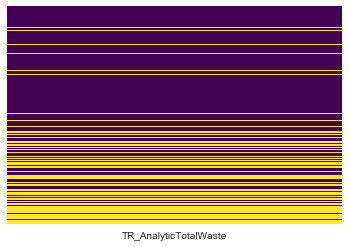

In [86]:
co2.display_missing_heatmap('TR_AnalyticTotalWaste')